In [1]:
%load_ext autoreload
%autoreload 2
from utils import *

messages = ['0300001611e00000000700c1020200c2020202c0010a',\
           '0300001611d00007000300c1020200c2020202c0010a',\
           '0300001902f08032010000020000080000f0000001000101e0',\
           '0300001b02f080320300000200000800000000f0000001000100f0',\
           '0300001f02f080320700000e00000800060001120411430200ff0900023038',\
           '0300001f02f080320700001000000800060001120411430200ff0900023042',\
           '0300002502f080320700000e00000c0008000112081283020100000000ff09000400012203',\
           '0300005102f080320700001000000c0034000112081283020100000000ff09003000002207000122070002221100032207000422070007220700c8221002bd22100bb8220703e8220703ea220703e92207',\
           '0300001611e00000000100c1020100c2020102c00109',\
           '0300001611d00001000300c00109c1020100c2020102',\
           '0300001902f08032010000ffff00080000f000000100010780',\
           '0300001b02f08032030000ffff000800000000f0000001000100f0',\
           '0300001f02f080320100000001000e00000401120a10020010000083000000',\
           '0300002902f0803203000000010002001400000401ff040080a9100000000001010000000000000000',\
           '0300004302f080320100004500003200000404120a1009000700011d00a2d4120a100900f2008b8300f281120a100900ce004a81004558120a101c0039002a83001a38',\
           '0300003d02f0803203000045000002002800000404ff090008434c574e4a734f52ff0900086a35645776537954ff0900027568ff090006595979456c4a']

# messages = '../s7-new.txt'
# messages = '../s7-32-1000-req.pcap'

if type(messages) == str:
    messages = filepreprocess(messages)
elif type(messages) == list or type(messages) == np.ndarray:
    messages = messages
else:
    print('type error')

熵值分析：计算所有位置的熵值，滤波后，得到熵激增点的位置作为header和payload的分界处；
也可以针对个别报文，计算其个体熵对总体熵的占比，来得到个别报文自身的header与payload的分界。

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
27
23


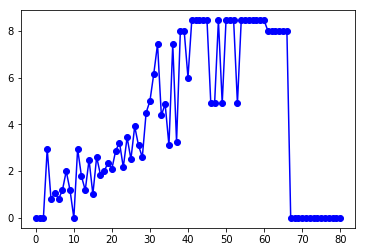

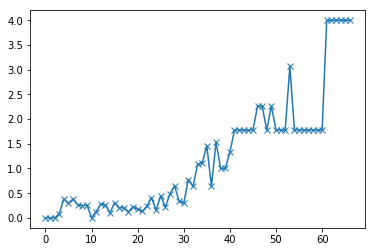

In [3]:
%load_ext autoreload
%autoreload 2

from MsgEntropy import MsgEntropy

msgEntropy = MsgEntropy()

finalpos = msgEntropy.find_payloadpos(messages)

print(finalpos) ### 总体报文的 header 和 payload 的分界处

m14finalpos = msgEntropy.find_singlepos(messages,14)

print(m14finalpos) ### 个体报文的 header 和 payload 的分界处

plotfinal = msgEntropy.plot_entro(messages) ### 总体报文的熵

plotm14 = msgEntropy.plot_single(messages,14) ### 个体报文的熵

N-grams 分析：对报头分别进行 1-gram，2-grams-大端，2-grams-小端，... ，4-grams-小端 的切分，并计算各片段间的关联性：
1. 固定 Fix，值
2. 长度： Len, K, B: Len = K * pos + B  
3. Pearson Correlation: Cor, K, B, Pos2 : Pos2 = K * pos + B
4. MIC (Maximal Information Coefficient): Mic, Pos2

In [4]:
dataset = msgEntropy.dataset

Header = [strpreprocess(dataset[i][:finalpos],'str') for i in range(len(dataset))]

from Ngrams import *
fieldTypes = Ngrams(Header)

Lengths = [int(len(messages[i])/2) for i in range(len(messages))]

fieldtypes = FindFieldType(fieldTypes,Lengths,MicFlag = 0) ### MIC 这里不显示
for n in fieldtypes:
    for i in range(len(fieldtypes[n])):
        if len(fieldtypes[n][i].bigRelation) > 0:
            print(fieldtypes[n][i].pos)
            print(fieldtypes[n][i].bigRelation) ### 这里仅显示大端读数下的所有结果

/home/dianfeng/anaconda3/envs/python3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/dianfeng/anaconda3/envs/python3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dianfeng/anaconda3/envs/python3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(0, 0)
[('Fix', 3)]
(1, 1)
[('Fix', 0)]
(2, 2)
[('Fix', 0)]
(3, 3)
[('Len', 1.0, -0.0)]
(10, 10)
[('Fix', 0)]
(0, 1)
[('Fix', 768)]
(1, 2)
[('Fix', 0)]
(2, 3)
[('Len', 1.0, -0.0)]
(0, 2)
[('Fix', 196608)]
(1, 3)
[('Len', 1.0, -0.0)]


FP-Tree 频繁项分析（所有报文），'位置-值'，支持度默认 0.5， 
符合支持度的最大子集在frequent_k_itemsets_list中，对应的频数为frequent_k_itemsets_sup_list
FP-Tree 图打印

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[['0000-03', '0001-00', '0002-00', '000a-00', '0004-02', '0005-f0', '0006-80', '0007-32', '0009-00', '000d-00', '000f-00', '0011-00'], ['0000-03', '0001-00', '0002-00', '000a-00', '0004-02', '0005-f0', '0006-80', '0007-32', '0009-00', '000d-00', '000f-00', '000c-00']] [8, 8]


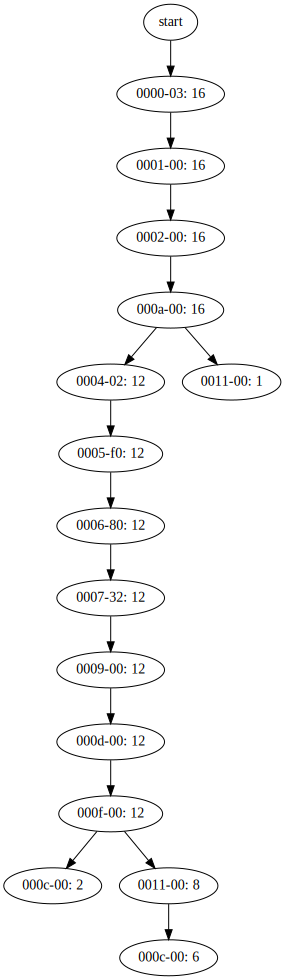

In [5]:
%load_ext autoreload
%autoreload 2

datapos = []
for i in range(len(messages)):
    tempstr = strpreprocess(messages[i],'bytelist')
    finalstr = []
    for j in range(len(tempstr)):
        finalstr.append('{:04x}'.format(j) + '-' + tempstr[j]) ### '位置-值'
    datapos.append(finalstr)


from FP_Tree import *
fp = FP_Tree()

fp.get_frequent_k_itemsets(datapos)

frequent_k_itemsets_list,frequent_k_itemsets_sup_list = fp.max_frequent_k_itemsets()
print(frequent_k_itemsets_list,frequent_k_itemsets_sup_list)

dot = fp.plotFPtree()
display(dot)

子报文抽取：对单个报文进行payload分析，抽取其内部的子报文，可将抽取出的子报文模板替代payload

In [6]:
%load_ext autoreload
%autoreload 2

from SubMsg import SubMsg

print('Use the real pos:')
print('---------------')
subMsg = SubMsg()
flag = subMsg.execute_pos(messages[14],19) 
if flag == True:
    print(subMsg.newMsg)
    print(subMsg.template)
else:
    print('No sub-Msg')
print('---------------')


print('Use the inferred pos in Entropy analysis:')
print('---------------')
subMsg = SubMsg()
flag = subMsg.execute_pos(messages[14],m14finalpos) 
if flag == True:
    print(subMsg.newMsg)
    print(subMsg.template)
else:
    print('No sub-Msg')
print('---------------')

print('Use the inferred ACF rear part:')
print('---------------')
subMsg = SubMsg(thred = 0.5,  precent = .98)
flag = subMsg.execute_rear(messages[14])
if flag == True:
    print(subMsg.newMsg)
    print(subMsg.template)
else:
    print('No sub-Msg')
print('---------------')
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Use the real pos:
---------------
['03', '00', '00', '43', '02', 'f0', '80', '32', '01', '00', '00', '45', '00', '00', '32', '00', '00', '04', '04', '12', '0a', '10', '0e', '00', '80', '00', '40', '69', '00', '7d', '79']
['12', '0a', '10', '0e', '00', '80', '00', '40', '69', '00', '7d', '79']
---------------
Use the inferred pos in Entropy analysis:
---------------
['03', '00', '00', '43', '02', 'f0', '80', '32', '01', '00', '00', '45', '00', '00', '32', '00', '00', '04', '04', '12', '0a', '10', '09', '14', '00', '00', '47', '82', '00', '9e', '8f', '12', '0a', '10']
['14', '00', '00', '47', '82', '00', '9e', '8f', '12', '0a', '10']
---------------
Use the inferred ACF rear part:
---------------
['03', '00', '00', '43', '02', 'f0', '80', '32', '01', '00', '00', '45', '00', '00', '32', '00', '00', '04', '04', '12', '0a', '10', '09', '00', '07', '00', '01', '1d', '00', '9e', '8f', '12', '0a', '10', '0f

用subMsg更新所有messages

In [7]:
subMsg = SubMsg(thred = 0.5,  precent = .98)
newMsg = []
for message in messages:
    flag = subMsg.execute_rear(message) 
    if flag == True:
        newMsg.append(subMsg.newMsg)
    else:
        newMsg.append(strpreprocess(message,'bytelist'))


/home/dianfeng/anaconda3/envs/python3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:546: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


获得协议类型Command label

In [8]:
from TrueCommand import *
truelabel = []
for message in messages:
    truelabel.append(s7type(message))

print('truelabel: ',truelabel)

truelabel:  ['CR_TPDU', 'CC_TPDU', 'Job_Setup_communication', 'Ack_Data_Setup_communication', 'Request_Block_function_List_blocks_of_type', 'Request_Block_function_List_blocks_of_type', 'Response_Block_function_List_blocks_of_type', 'Response_Block_function_List_blocks_of_type', 'CR_TPDU', 'CC_TPDU', 'Job_Setup_communication', 'Ack_Data_Setup_communication', 'Job_Read_Var', 'Ack_Data_Read_Var', 'Job_Read_Var', 'Ack_Data_Read_Var']


LDA聚类

In [9]:
from LDA import LDA
Lda = LDA()
score, inferlabel = Lda.execute(messages)

INFO:lda:n_documents: 16
INFO:lda:vocab_size: 256
INFO:lda:n_words: 572
INFO:lda:n_topics: 10
INFO:lda:n_iter: 15000
INFO:lda:<0> log likelihood: -4133
INFO:lda:<10> log likelihood: -2492
INFO:lda:<20> log likelihood: -2441
INFO:lda:<30> log likelihood: -2344
INFO:lda:<40> log likelihood: -2339
INFO:lda:<50> log likelihood: -2306
INFO:lda:<60> log likelihood: -2318
INFO:lda:<70> log likelihood: -2267
INFO:lda:<80> log likelihood: -2250
INFO:lda:<90> log likelihood: -2298
INFO:lda:<100> log likelihood: -2309
INFO:lda:<110> log likelihood: -2280
INFO:lda:<120> log likelihood: -2229
INFO:lda:<130> log likelihood: -2265
INFO:lda:<140> log likelihood: -2243
INFO:lda:<150> log likelihood: -2174
INFO:lda:<160> log likelihood: -2265
INFO:lda:<170> log likelihood: -2193
INFO:lda:<180> log likelihood: -2168
INFO:lda:<190> log likelihood: -2197
INFO:lda:<200> log likelihood: -2232
INFO:lda:<210> log likelihood: -2195
INFO:lda:<220> log likelihood: -2223
INFO:lda:<230> log likelihood: -2274
INFO:l

INFO:lda:<2140> log likelihood: -2110
INFO:lda:<2150> log likelihood: -2111
INFO:lda:<2160> log likelihood: -2118
INFO:lda:<2170> log likelihood: -2101
INFO:lda:<2180> log likelihood: -2167
INFO:lda:<2190> log likelihood: -2109
INFO:lda:<2200> log likelihood: -2141
INFO:lda:<2210> log likelihood: -2126
INFO:lda:<2220> log likelihood: -2118
INFO:lda:<2230> log likelihood: -2159
INFO:lda:<2240> log likelihood: -2126
INFO:lda:<2250> log likelihood: -2077
INFO:lda:<2260> log likelihood: -2108
INFO:lda:<2270> log likelihood: -2102
INFO:lda:<2280> log likelihood: -2105
INFO:lda:<2290> log likelihood: -2105
INFO:lda:<2300> log likelihood: -2153
INFO:lda:<2310> log likelihood: -2160
INFO:lda:<2320> log likelihood: -2103
INFO:lda:<2330> log likelihood: -2106
INFO:lda:<2340> log likelihood: -2124
INFO:lda:<2350> log likelihood: -2091
INFO:lda:<2360> log likelihood: -2106
INFO:lda:<2370> log likelihood: -2111
INFO:lda:<2380> log likelihood: -2101
INFO:lda:<2390> log likelihood: -2123
INFO:lda:<24

INFO:lda:<4300> log likelihood: -2132
INFO:lda:<4310> log likelihood: -2062
INFO:lda:<4320> log likelihood: -2138
INFO:lda:<4330> log likelihood: -2124
INFO:lda:<4340> log likelihood: -2158
INFO:lda:<4350> log likelihood: -2099
INFO:lda:<4360> log likelihood: -2092
INFO:lda:<4370> log likelihood: -2116
INFO:lda:<4380> log likelihood: -2107
INFO:lda:<4390> log likelihood: -2084
INFO:lda:<4400> log likelihood: -2091
INFO:lda:<4410> log likelihood: -2097
INFO:lda:<4420> log likelihood: -2115
INFO:lda:<4430> log likelihood: -2103
INFO:lda:<4440> log likelihood: -2087
INFO:lda:<4450> log likelihood: -2108
INFO:lda:<4460> log likelihood: -2093
INFO:lda:<4470> log likelihood: -2110
INFO:lda:<4480> log likelihood: -2093
INFO:lda:<4490> log likelihood: -2099
INFO:lda:<4500> log likelihood: -2103
INFO:lda:<4510> log likelihood: -2113
INFO:lda:<4520> log likelihood: -2138
INFO:lda:<4530> log likelihood: -2080
INFO:lda:<4540> log likelihood: -2046
INFO:lda:<4550> log likelihood: -2120
INFO:lda:<45

INFO:lda:<6460> log likelihood: -2104
INFO:lda:<6470> log likelihood: -2078
INFO:lda:<6480> log likelihood: -2087
INFO:lda:<6490> log likelihood: -2084
INFO:lda:<6500> log likelihood: -2074
INFO:lda:<6510> log likelihood: -2093
INFO:lda:<6520> log likelihood: -2127
INFO:lda:<6530> log likelihood: -2143
INFO:lda:<6540> log likelihood: -2086
INFO:lda:<6550> log likelihood: -2179
INFO:lda:<6560> log likelihood: -2133
INFO:lda:<6570> log likelihood: -2110
INFO:lda:<6580> log likelihood: -2096
INFO:lda:<6590> log likelihood: -2113
INFO:lda:<6600> log likelihood: -2077
INFO:lda:<6610> log likelihood: -2109
INFO:lda:<6620> log likelihood: -2104
INFO:lda:<6630> log likelihood: -2079
INFO:lda:<6640> log likelihood: -2128
INFO:lda:<6650> log likelihood: -2118
INFO:lda:<6660> log likelihood: -2059
INFO:lda:<6670> log likelihood: -2103
INFO:lda:<6680> log likelihood: -2105
INFO:lda:<6690> log likelihood: -2101
INFO:lda:<6700> log likelihood: -2100
INFO:lda:<6710> log likelihood: -2107
INFO:lda:<67

INFO:lda:<8620> log likelihood: -2106
INFO:lda:<8630> log likelihood: -2136
INFO:lda:<8640> log likelihood: -2150
INFO:lda:<8650> log likelihood: -2104
INFO:lda:<8660> log likelihood: -2094
INFO:lda:<8670> log likelihood: -2130
INFO:lda:<8680> log likelihood: -2101
INFO:lda:<8690> log likelihood: -2095
INFO:lda:<8700> log likelihood: -2123
INFO:lda:<8710> log likelihood: -2136
INFO:lda:<8720> log likelihood: -2170
INFO:lda:<8730> log likelihood: -2126
INFO:lda:<8740> log likelihood: -2104
INFO:lda:<8750> log likelihood: -2114
INFO:lda:<8760> log likelihood: -2084
INFO:lda:<8770> log likelihood: -2098
INFO:lda:<8780> log likelihood: -2121
INFO:lda:<8790> log likelihood: -2124
INFO:lda:<8800> log likelihood: -2132
INFO:lda:<8810> log likelihood: -2098
INFO:lda:<8820> log likelihood: -2095
INFO:lda:<8830> log likelihood: -2171
INFO:lda:<8840> log likelihood: -2147
INFO:lda:<8850> log likelihood: -2127
INFO:lda:<8860> log likelihood: -2116
INFO:lda:<8870> log likelihood: -2095
INFO:lda:<88

INFO:lda:<10760> log likelihood: -2090
INFO:lda:<10770> log likelihood: -2105
INFO:lda:<10780> log likelihood: -2102
INFO:lda:<10790> log likelihood: -2103
INFO:lda:<10800> log likelihood: -2116
INFO:lda:<10810> log likelihood: -2084
INFO:lda:<10820> log likelihood: -2125
INFO:lda:<10830> log likelihood: -2114
INFO:lda:<10840> log likelihood: -2149
INFO:lda:<10850> log likelihood: -2166
INFO:lda:<10860> log likelihood: -2084
INFO:lda:<10870> log likelihood: -2081
INFO:lda:<10880> log likelihood: -2133
INFO:lda:<10890> log likelihood: -2086
INFO:lda:<10900> log likelihood: -2112
INFO:lda:<10910> log likelihood: -2135
INFO:lda:<10920> log likelihood: -2083
INFO:lda:<10930> log likelihood: -2112
INFO:lda:<10940> log likelihood: -2137
INFO:lda:<10950> log likelihood: -2117
INFO:lda:<10960> log likelihood: -2124
INFO:lda:<10970> log likelihood: -2114
INFO:lda:<10980> log likelihood: -2140
INFO:lda:<10990> log likelihood: -2132
INFO:lda:<11000> log likelihood: -2131
INFO:lda:<11010> log like

INFO:lda:<12870> log likelihood: -2152
INFO:lda:<12880> log likelihood: -2114
INFO:lda:<12890> log likelihood: -2075
INFO:lda:<12900> log likelihood: -2104
INFO:lda:<12910> log likelihood: -2114
INFO:lda:<12920> log likelihood: -2065
INFO:lda:<12930> log likelihood: -2121
INFO:lda:<12940> log likelihood: -2068
INFO:lda:<12950> log likelihood: -2089
INFO:lda:<12960> log likelihood: -2095
INFO:lda:<12970> log likelihood: -2110
INFO:lda:<12980> log likelihood: -2120
INFO:lda:<12990> log likelihood: -2163
INFO:lda:<13000> log likelihood: -2137
INFO:lda:<13010> log likelihood: -2089
INFO:lda:<13020> log likelihood: -2112
INFO:lda:<13030> log likelihood: -2123
INFO:lda:<13040> log likelihood: -2144
INFO:lda:<13050> log likelihood: -2165
INFO:lda:<13060> log likelihood: -2108
INFO:lda:<13070> log likelihood: -2121
INFO:lda:<13080> log likelihood: -2161
INFO:lda:<13090> log likelihood: -2073
INFO:lda:<13100> log likelihood: -2091
INFO:lda:<13110> log likelihood: -2094
INFO:lda:<13120> log like

INFO:lda:<14980> log likelihood: -2148
INFO:lda:<14990> log likelihood: -2094
INFO:lda:<14999> log likelihood: -2097


ari:  0.09090909090909091
------------------
ami:  0.26767294961336163
------------------
nmi:  0.4257249657287938
------------------
h_score:  0.2704260414863776
c_score:  1.0
v_measure:  0.4257249657287938
------------------
fmi:  0.3333333333333333


netzob 聚类 by NW Aligment

In [10]:
%load_ext autoreload
%autoreload 2
from Netzob import Netzob
nz = Netzob()
score, inferlabel = nz.cluster(messages)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ari:  0.09909909909909911
------------------
ami:  0.2129238742039991
------------------
nmi:  0.5689806004971363
------------------
h_score:  0.44730572889623316
c_score:  0.7815852721917027
v_measure:  0.5689806004971363
------------------
fmi:  0.2727723627949905


这里应该是多个文件（相当于多个session），每个文件都被聚类了的，先用单文件聚类，然后reshape当作有多个文件

In [11]:
text = np.array(inferlabel).reshape(int(len(inferlabel)/2),2) 

前缀树接受器

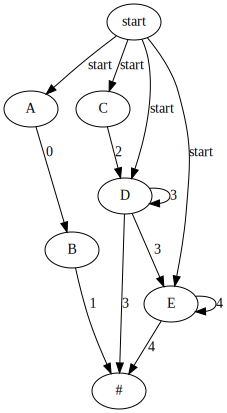

In [12]:
from PTA import PTA
pta = PTA()
for txt in text:
    pta.insert(txt)

dot = pta.printTree()
display(dot)